# Trabalho Final - Deep Learning - Análise de Sentimentos

**FURB - Data Science - Turma 02**<br>
**Aluno:** Felipe Eduardo Gomes <br>
**Baseado no projeto:** https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch

---



### Classificação de textos para análise de sentimentos

Base de dados 

Instruções:
- O objetivo deste trabalho é criar um modelo binário de aprendizado de máquina para classificação de textos. 
Para isso, será utilizado a base de dados [IMDb](http://ai.stanford.edu/~amaas/data/sentiment/), que consiste de dados textuais de críticas positivas e negativas de filmes
- Uma vez treinado, o modelo deve ter uma função `predict` que recebe uma string como parâmetro e retorna o valor 1 ou 0, aonde 1 significa uma crítica positiva e 0 uma crítica negativa
- O pré-processamento pode ser desenvolvidado conforme desejar (ex.: remoção de stopwords, word embedding, one-hot encoding, char encoding)
- É preferível que seja empregado um modelo de recorrência (ex.: rnn, lstm, gru) para a etapa de classificação
- Documente o código (explique sucintamente o que cada função faz, insira comentários em trechos de código relevantes)
- **Atenção**: Uma vez treinado o modelo final, salve-o no diretório do seu projeto e crie uma célula ao final do notebook contendo uma função de leitura deste arquivo, juntamente com a execução da função `predict`

Sugestões:
- Explorar a base de dados nas células iniciais do notebook para ter um melhor entendimento do problema, distribuição dos dados, etc
- Após desenvolver a estrutura de classificação, é indicado fazer uma busca de hiperparâmetros e comparar os resultados obtidos em diferentes situações

Prazo de entrega:
- 01-08-2021 às 23:59hs GMT-3

Formato preferível de entrega:
- Postar no portal Ava da disciplina o link do projeto no github (ou anexar o projeto diretamente no portal Ava)

luann.porfirio@gmail.com

###Imports de biblioteca e verificação de dispositivo de hardware

In [1]:
!pip install torchtext

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import datasets
from nltk.corpus import stopwords 
from collections import Counter
from sklearn.model_selection import train_test_split
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print('Using {} device'.format(device))

Using cuda device


### Ativar o Google Drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Carregar banco de dados e dividir o dataset em treino e teste.

In [5]:
train_iter, test_iter = datasets.IMDB()
ds_imdb = list(train_iter + test_iter)

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:00<00:00, 94.7MB/s]


###Carregar o dataset para um Dataframe (Pandas)

In [6]:
df = pd.DataFrame(data=ds_imdb, columns=['sentiment', 'review'])

###Exibe a estrutura do dataframe

In [7]:
df.head()

,sentiment,review
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."


###Informações do Dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  50000 non-null  object
 1   review     50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


###Exibe o resumo do Dataset

In [9]:
df.describe()

,sentiment,review
count,50000,50000
unique,2,49582
top,neg,Loved today's show!!! It was a variety and not...
freq,25000,5


###Separar os dados em treino e teste

In [10]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


###Plotar análise de sentimentos

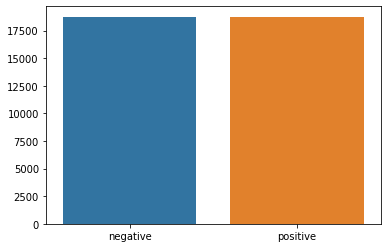

In [11]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

###Tratamento das strings removendo caracteres (com exceção de letras e números) e espaços em branco

In [12]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

###Tokenização de palavras removendo stopwords

In [13]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [14]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


###Imprimir tamanho do vocabulário

In [15]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


###Analisando tamanho do review

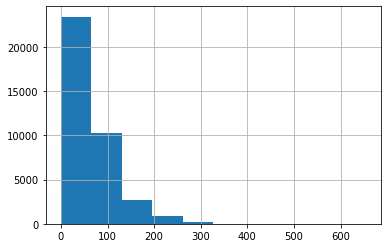

count    37500.000000
mean        69.080693
std         47.958646
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        653.000000
dtype: float64

In [16]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

###Padding - Preenche as sequencias até o máximo de comprimento

In [17]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

###Temos um número muito pequeno de reviews com tamanho maior que 500. Iremos considerar somente os reviews abaixo desta quantidade.

In [18]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

###Definindo os lotes e carregando como tensor

In [19]:
# Criando Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# Embaralhando os dados
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

### Obtendo um lote de dados de treino

In [20]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  11,   2, 236],
        [  0,   0,   0,  ..., 374,   3, 416],
        [  0,   0,   0,  ...,  35,  15,  55],
        ...,
        [  0,   0,   0,  ..., 234, 410, 503],
        [  0,   0,   0,  ...,   1, 286,   1],
        [  0,   0,   0,  ...,   8,  15, 550]])
Sample input: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


Precisamos adicionar uma camada de incorporação porque há poucas palavras em nosso vocabulário. É extremamente ineficiente para codificar one-hot tantas classes. Portanto, em vez de codificação one-hot, podemos ter uma camada de incorporação e usar essa camada como uma tabela de pesquisa. É possível treinar uma camada de incorporação usando Word2Vec e carregá-la aqui. Mas não há problema em apenas fazer uma nova camada, usando-a apenas para redução de dimensionalidade, e deixar a rede aprender os pesos. 

### Implementando o Modelo

In [21]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding e camadas LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # camada dropout
        self.dropout = nn.Dropout(0.3)
    
        # camada linear e sigmoid
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings e lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout e camada totalmente conectada
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # função sigmoid
        sig_out = self.sig(out)
        
        # reshape para batch_size primeirp
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # pegar último batch de labels
        
        # retornar última saída sigmoid e hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Criar dois novos tensors com tamanhos n_layers x batch_size x hidden_dim,
        # Inicializado com zero, para hidden state e cell state do LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [22]:
no_layers = 2
vocab_size = len(vocab) + 1 # 1 extra para padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

# Processar na GPU se estiver disponível
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


###Hiperparâmetros

In [23]:
lr=0.001 # Funções de perda e otimização
clip = 5
epochs = 5 # Épocas

###Treinando

In [24]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Função para calcular acurácia
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [25]:
valid_loss_min = np.Inf
# Treinar algumas épocas
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # Inicializar o hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Criando novas variáveis para o hidden state, caso contrário
        # voltaríamos a propagação por todo o histórico de treinamento.
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # Calcular a perda e fazer o backpropagation
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # Calcular acurácia
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` ajuda a prevenir o problema de gradiente explosivo em RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    #if epoch_val_loss <= valid_loss_min:
    #    torch.save(model.state_dict(), '../working/state_dict.pt')
    #    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    #    valid_loss_min = epoch_val_loss
    print(25*'==')


# Salvar o modelo treinado
model_path = '/content/drive/MyDrive/FURB/trabalho_deep_learning_state_dict.pt'
torch.save(model.state_dict(), model_path)

Epoch 1
train_loss : 0.004931729753044541 val_loss : 1.060968224919634e-05
train_accuracy : 99.86933333333333 val_accuracy : 100.0
Epoch 2
train_loss : 7.333997688571495e-06 val_loss : 3.6358896977617405e-06
train_accuracy : 100.0 val_accuracy : 100.0
Epoch 3
train_loss : 3.0584739018498414e-06 val_loss : 1.7881409348774469e-06
train_accuracy : 100.0 val_accuracy : 100.0
Epoch 4
train_loss : 1.6032143166739843e-06 val_loss : 9.536747711536009e-07
train_accuracy : 100.0 val_accuracy : 100.0
Epoch 5
train_loss : 9.357411527162185e-07 val_loss : 5.960466182841628e-07
train_accuracy : 100.0 val_accuracy : 100.0


### Plotar gráfico de Acurácia x Perda

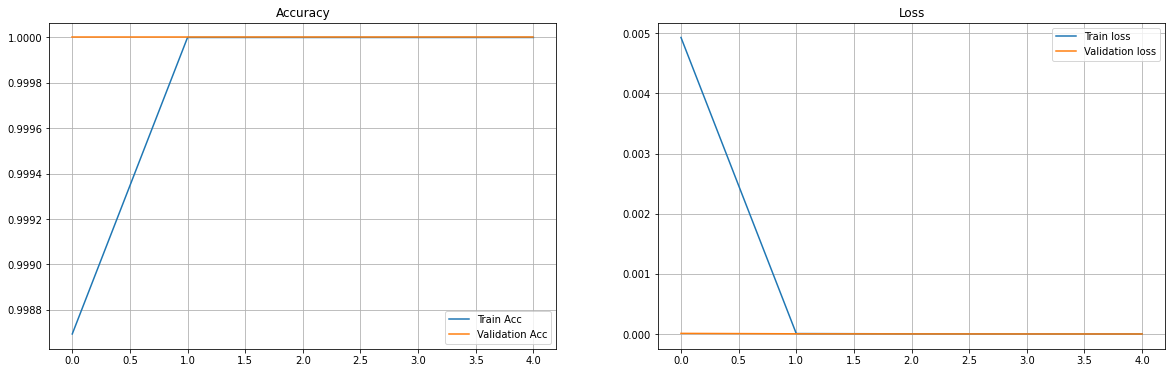

In [26]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Carregar o modelo treinado para predição

In [32]:
no_layers = 2
vocab_size = 1000 + 1 # 1 extra para padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

# Cria a rede e carrega o modelo treinado.
model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

model.load_state_dict(torch.load('/content/drive/MyDrive/FURB/trabalho_deep_learning_state_dict.pt'), strict=False)

# Passar para GPU, se tiver
model.to(device)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [33]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

### Testar a predição de um elemento do dataframe, que irá retornar se o sentimento é positivo ou negativo

In [34]:
index = 1713
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Well, maybe I'm just having a bad run with Hindi movies lately. I asked the video store guy for Apharan (Prakash Jha) but being a new release, wasn't available yet. So I had to settle for this one. It turned out to be the stupidest Hindi movie I've seen (and I've seen quite a few). No wonder BOllywood is the laughing stock of the whole world! If IMDb had negative ratings, I would give Garam Masala a -10.<br /><br />I remember seeing a TV show about the jazzy premiere they had for its release in Mumbai. All the usual celebs and their sideys showed up. For some strange reason, people expect good stuff from Piyadarashan. I did not like Hulchul, Hungama, or his other films. Hulchul, probably dubbed from Tamil or Telugu, came across as very loud, in-your-face fare that again didn't make much sense except in a Bollywood flick. This latest piece of utter CXXP proved that this guy has NO BRAINS. Who made him a director, even a Bollywood director at that??? <br /><br />Anyhow, to the film now. 